In [1]:
import pandas as pd

import statsmodels.api as sm
import pandas as pd
import datetime
from pathlib import Path

pd.set_option("display.max_columns", None)
# !pip install statsmodels


# %config InlineBackend.figure_format = "svg"
# %config InlineBackend.print_figure_kwargs = {"dpi" : 300}
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# from cadFace.vis import percentiles_plot
import sci_palettes

try:
    sci_palettes.register_cmap()
except:
    pass
import scienceplots
from pathlib import Path
import pandas as pd
from ppp_aging.ppp_model import *
from ppp_aging.model import generate_states_cols
import json

plt.style.use(["nature", "no-latex"])
sns.set_context("paper", font_scale=1.5)
sns.set_palette("nejm")

In [30]:
from cuml import LogisticRegression, Lasso, Ridge, ElasticNet
from cuml.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer


def fit_best_model(train_df, test_df, X_var, y_var, method_list=None, cv=10, verbose=1):
    models_params = {
        "Logistic": {
            "model": LogisticRegression(
                solver="qn", random_state=42, class_weight="balanced"
            ),
            "param_grid": {
                "C": np.logspace(-4, 4, 10),  # C参数的范围，使用对数间隔
                "penalty": ["l1"],  # 正则化类型
            },
        },
        "Lasso": {
            "model": Lasso(),
            "param_grid": {
                "alpha": np.logspace(-4, 4, 10),
            },
        },
        "ElasticNet": {
            "model": ElasticNet(),
            "param_grid": {
                "alpha": np.logspace(-4, 4, 10),
                "l1_ratio": np.linspace(0, 1, 10),
            },
        },
        # "RandomForest": {
        #     "model": RandomForestClassifier(),
        #     "param_grid": {"n_estimators": range(10, 101, 10)},
        # },
    }
    if method_list is not None:
        models_params = {k: v for k, v in models_params.items() if k in method_list}

    train_df = train_df[[y_var] + X_var].copy().dropna()
    test_df = test_df[[y_var] + X_var].copy().dropna()
    train_df[y_var] = train_df[y_var].astype(int)
    test_df[y_var] = test_df[y_var].astype(int)

    train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

    X_train = train_df[X_var]
    y_train = train_df[y_var]
    X_val = val_df[X_var]
    y_val = val_df[y_var]

    X_test = test_df[X_var]
    y_test = test_df[y_var]
    print(
        f"train shape: {X_train.shape}, val shape is {X_val.shape}, test shape is {X_test.shape}"
    )
    best_models = []

    for model_name, mp in models_params.items():
        # if model_name == "RandomForest":
        #     best_model = RandomForestClassifier(verbose=verbose)
        #     best_model.fit(X_train.values, y_train.values)
        #     auc = roc_auc_score(y_val, best_model.predict(X_val.values))
        #     bset_params = None  # no params for RandomForest

        # else:
        if model_name == "Logistic":
            scorer = make_scorer(roc_auc_score, needs_proba=True)
        else:
            scorer = make_scorer(roc_auc_score)

        grid_search = GridSearchCV(
            mp["model"], mp["param_grid"], scoring=scorer, cv=cv, verbose=verbose
        )
        grid_search.fit(X_train.values, y_train.values)

        best_model = grid_search.best_estimator_
        bset_params = grid_search.best_params_

        if model_name == "Logistic":
            auc = roc_auc_score(y_val, best_model.predict_proba(X_val.values)[:, 1])
        else:
            auc = roc_auc_score(y_val, best_model.predict(X_val.values))
        print(f"model: {model_name}\tBest parameters: {bset_params}, with auc: {auc}")
        best_models.append((model_name, best_model, grid_search, auc))

    ## select the currently best
    # print(best_models)

    # 还原原始的train_df
    train_df = pd.concat([train_df, val_df], axis=0)
    X_train = train_df[X_var]
    y_train = train_df[y_var]

    best_mdoels = list(sorted(best_models, key=lambda x: x[-1], reverse=True))
    best_model_name, best_model, *_ = best_mdoels[0]

    if best_model_name == "Logistic":
        train_pred = best_model.predict_proba(X_train.values)[:, 1]

        test_pred = best_model.predict_proba(X_test.values)[:, 1]
    else:
        train_pred = best_model.predict(X_train.values)
        val_pred = best_model.predict(X_val.values)
        test_pred = best_model.predict(X_test.values)

    train_df[f"{y_var}_pred"] = train_pred

    test_df[f"{y_var}_pred"] = test_pred

    train_auc = roc_auc_score(y_train, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)

    train_metrics = {
        "train_auc": train_auc,
    }
    test_metrics = {
        "test_auc": test_auc,
    }
    return best_model, train_metrics, test_metrics, train_df, test_df, best_mdoels


class Bootstrapdf:
    def __init__(self, df, n_resample=100):
        self.df = df
        self.n_resample = n_resample

    def __iter__(self):
        for i in range(self.n_resample):
            yield self.df.sample(frac=1, replace=True, random_state=i)


from tqdm.rich import tqdm
import numpy as np
from functools import reduce


class EnsembleModel(object):
    def __init__(self, models, coef_name=None, model_name_list=None, tgt_name=None):
        self.models = models

        if coef_name is None:
            if hasattr(self.models[0], "feature_names_in_"):
                coef_name = self.models[0].coef_name
            else:
                raise ValueError("coef_name should be provided")
        else:
            coef_name = coef_name
        self.features = coef_name if coef_name else self.models[0].coef_name

        self.model_name_list = (
            model_name_list
            if model_name_list
            else [f"model_{i}" for i in range(len(self.models))]
        )

        self.res = self._init_coeffeients_df()

    def _init_coeffeients_df(self):

        res = pd.concat(
            [
                pd.DataFrame(
                    model_each.coef_,
                    index=self.features,
                    columns=["coefficients"],
                ).sort_values("coefficients", ascending=False)
                for model_each in self.models
            ],
            axis=1,
        )
        res.columns = [f"model_{i}" for i in range(len(self.model_name_list))]
        return res

    def _show_models_coeffients(self, axes=None, color="#d67b7f", top=5):
        """
        res:
            model1 model2
        SOST xx yy
        BGN xx yy


        """
        if self.res is None:
            self.res = self._init_coeffeients_df()
        res = self.res.loc[self.features, :]

        if axes is None:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        else:
            assert len(axes) == 2, "axes should be a list of length 2"
            ax1, ax2 = axes

        percent_of_nonZero_coefficients = (
            (res != 0).sum(axis=1) * 100 / len(res.columns)
        )
        mean_coefficients = res.mean(axis=1)
        plt_data = pd.DataFrame(
            [percent_of_nonZero_coefficients, mean_coefficients],
            index=["percent_of_nonZero_coefficients", "mean_coefficients"],
        ).T
        plt_data["abs_mean_coefficients"] = plt_data["mean_coefficients"].abs()

        # ax1
        sns.scatterplot(
            x=percent_of_nonZero_coefficients,
            y=mean_coefficients,
            size=mean_coefficients,
            sizes=(20, 400),
            legend=False,
            edgecolor="black",
            ax=ax1,
            color=color,
        )
        ax1.plot([0, 100], [0, 0], "k--", lw=3, color="grey")
        ax1.set_xlim(-1, 105)
        ax1.set_xlabel("percent of non-zero coefficients")
        ax1.set_ylabel("mean nonzero coefficients")
        sorted_plt_data = (
            plt_data.sort_values(
                by=["percent_of_nonZero_coefficients", "abs_mean_coefficients"],
                ascending=False,
            )
            .iloc[:top, :]
            .index
        )
        for i, txt in enumerate(sorted_plt_data):
            # ax1.annotate(txt, (sorted_plt_data.iloc[i, 0], sorted_plt_data.iloc[i, 1]))
            ax1.text(
                plt_data.loc[txt, "percent_of_nonZero_coefficients"],
                plt_data.loc[txt, "mean_coefficients"],
                txt,
                ha="right",
                fontsize=8,
                color="black",
            )

        # ax2
        absolute_mean_coefficients = mean_coefficients.abs().sort_values(ascending=True)
        sns.barplot(
            y=absolute_mean_coefficients,
            x=absolute_mean_coefficients.index,
            ax=ax2,
            color=color,
        )
        ax2.set_ylabel("absolute mean coefficients")
        ax2.set_xlabel("")
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
        if axes is None:
            fig.tight_layout()
            return fig

    def predict(self, data):
        preds = []
        for model in self.models:
            if hasattr(model, "predict_proba"):
                preds.append(model.predict_proba(data)[:, 1])
            else:
                preds.append(model.predict(data))
        return np.mean(preds, axis=0)

    def predict_df(self, data):

        data[f"pred_{self.label}"] = self.predict(data)
        if not self.loess:
            self.fit_loess(data)
            print("Fitting loess since not provided.")
        data[f"pred_{self.label}_loess"] = self.loess.predict(
            data[self.label].values
        ).values

        data[f"{self.label}_gap"] = (
            data[f"pred_{self.label}"].values - data[f"pred_{self.label}_loess"].values
        )
        if not self.age_gap_scaler:
            self.fit_age_gap_scaler(data)
            print("Fitting age gap scaler since not provided.")
        data[f"{self.label}_gap_zscore"] = self.age_gap_scaler.transform(
            data[f"{self.label}_gap"].values.reshape(-1, 1)
        )
        return data


def fit_best_model_bootstrap(
    train_df,
    test_df,
    X_var,
    y_var,
    method_list=None,
    cv=10,
    verbose=1,
    n_resample=100,
    n_jobs=4,
):

    if n_jobs == 1:
        random_stats = [i for i in np.random.randint(0, 100000, n_resample)]
        res = []
        for i in tqdm(random_stats):
            train_df_sample = train_df.sample(frac=1, replace=True, random_state=i)
            best_model, *_ = fit_best_model(
                train_df_sample, test_df, X_var, y_var, method_list, cv, verbose
            )
            res.append(best_model)

    else:
        from joblib import Parallel, delayed

        print(f"n_jobs: {n_jobs}")
        random_stats = [i for i in np.random.randint(0, 100000, n_resample)]

        def fit_best_model_modified(*args):
            best_model, *_ = fit_best_model(*args)
            return best_model

        res = Parallel(n_jobs=n_jobs)(
            delayed(fit_best_model_modified)(
                train_df.sample(frac=1, replace=True, random_state=i),
                test_df,
                X_var,
                y_var,
                method_list,
                cv,
                verbose,
            )
            for i in tqdm(random_stats)
        )

    # list(reduce(lambda x, y: x + y, res))

In [32]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer(as_frame=True)
X = breast_cancer.data
y = breast_cancer.target.astype(float)

X_train = X[:400]
y_train = y[:400]
X_test = X[400:]
y_test = y[400:]
print(y.dtype)
print(X.shape)
# breast_cancer
import pandas as pd

total = pd.concat([breast_cancer.data, breast_cancer.target], axis=1)
model_list = fit_best_model_bootstrap(
    train_df=total.iloc[:400],
    test_df=total.iloc[400:],
    X_var=total.columns[:-1].tolist(),
    y_var=total.columns[-1],
    method_list=["Lasso"],
    cv=2,
    n_resample=10,
    n_jobs=2,
)

float64

(569, 30)

n_jobs: 2

/tmp/ipykernel_4127/1276421660.py:325: TqdmExperimentalWarning: rich is experimental/alpha
  for i in tqdm(random_stats)

LiveError: Only one live display may be active at once

In [16]:
model_list

[Lasso(),
 Lasso(),
 Lasso(),
 Lasso(),
 Lasso(),
 Lasso(),
 Lasso(),
 Lasso(),
 Lasso(),
 Lasso()]

In [24]:
em = EnsembleModel(
    models=model_list,
    coef_name=total.columns[:-1].tolist(),
)
em

In [29]:
pd.DataFrame([em.predict(X_test), y_test]).T

,0,1
0,-0.007524,0.0
1,0.911500,1.0
2,0.896467,1.0
3,0.862867,1.0
4,1.002384,1.0
...,...,...
164,-0.166085,0.0
165,-0.031808,0.0
166,0.265213,0.0
167,-0.557095,0.0


/tmp/ipykernel_4127/838882615.py:214: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([0, 100], [0, 0], "k--", lw=3, color="grey")
/tmp/ipykernel_4127/838882615.py:247: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


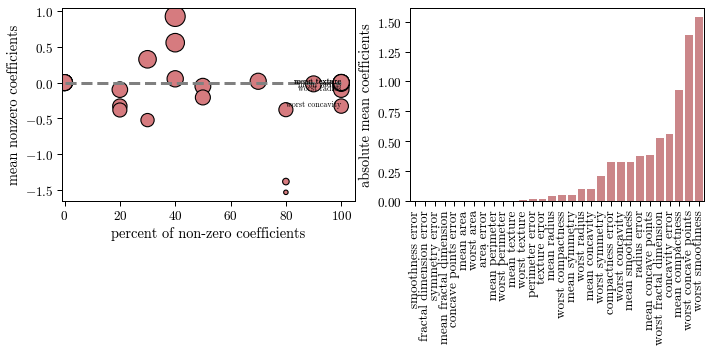

In [26]:
fig = em._show_models_coeffients()

## 读入数据

In [23]:
risk_factors = [
    "age",
    "sex",
    "ldl_a",
    "hdl_a",
    "tc_a",
    "tg_a",
    
    "apob",
    "sbp_a",
    "dbp_a",
]

E = "incident_cad"
T = "future_cad_time_months"

In [11]:
train_imputed = pd.read_pickle("1_train_imputed.pkl")
test_imputed = pd.read_pickle("1_test_imputed.pkl").dropna(
    subset=["PRS"] + risk_factors
)

X_combination = json.load(open("1_X_combination_dict.json"))

In [14]:
print(f"X_combination have {len(X_combination)} keys")
print(
    f"train_imputed shape is {train_imputed.shape}, test_imputed shape is {test_imputed.shape}"
)
print(
    f"train have {E}: {train_imputed[E].value_counts()}; test have {E}: {test_imputed[E].value_counts()}"
)

X_combination have 22 keys
train_imputed shape is (40806, 2966), test_imputed shape is (8298, 2966)
train have incident_cad: 0.0    38544
1.0     2262
Name: incident_cad, dtype: int64; test have incident_cad: 0.0    7859
1.0     439
Name: incident_cad, dtype: int64


In [19]:
from collections import OrderedDict

X_combination = OrderedDict(sorted(X_combination.items(), key=lambda x: len(x[1])))
X_combination

OrderedDict([('age_sex', ['age', 'sex']),
             ('PRS_age_sex', ['PRS', 'age', 'sex']),
             ('risk_factors',
              ['age',
               'sex',
               'ldl_a',
               'hdl_a',
               'tc_a',
               'tg_a',
               'apob',
               'sbp_a',
               'dbp_a']),
             ('PRS_risk_factors',
              ['PRS',
               'age',
               'sex',
               'ldl_a',
               'hdl_a',
               'tc_a',
               'tg_a',
               'apob',
               'sbp_a',
               'dbp_a']),
             ('single_surivival_sig_multivar_res_sig',
              ['NTproBNP',
               'MMP12',
               'VWC2',
               'SUSD2',
               'SIGLEC8',
               'EPS8L2',
               'CHGA',
               'ACTA2',
               'REN',
               'IL1RN',
               'RNASE4',
               'HSPB6',
               'CD99L2']),
             ('single_su

## fit best model

In [20]:
from collections import defaultdict
import pickle
from pathlib import Path

Regression_model_result_dict = defaultdict(dict)
output = "./1_regression_models"
Path(output).mkdir(exist_ok=True)

In [24]:
# %%time
methods = ["Lasso", "ElasticNet", "Logistic"]
cv = 10
for k, combination in X_combination.items():
    if k in Regression_model_result_dict.keys():
        print(f"{k} already in result dict")
        continue
    (
        model,
        train_metrics,
        test_metrics,
        train_imputed_data,
        test_imputed_data,
        best_models,
    ) = fit_best_model(
        train_df=train_imputed,
        test_df=test_imputed,
        X_var=X_combination[k],
        y_var=E,
        method_list=methods,
        cv=cv,
    )
    print(
        f"{k} train auc: {train_metrics['train_auc']}, test auc: {test_metrics['test_auc']}"
    )
    all_obj = {
        "model": model,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
        "train_data": train_imputed_data,
        "test_data": test_imputed_data,
        "best_models": best_models,
    }
    Regression_model_result_dict[k] = all_obj
    pickle.dump(all_obj, open(f"{output}/{k}.pkl", "wb"))

[I] [15:43:56.296896] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (36722, 2), val shape is (4081, 2), test shape is (8298, 2)
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


model: Logistic	Best parameters: {'C': 0.046415888336127774, 'penalty': 'l2'}, with auc: 0.7381355232750083
Fitting 10 folds for each of 10 candidates, totalling 100 fits
model: Lasso	Best parameters: {'alpha': 0.000774263682681127}, with auc: 0.7393122116834564
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
model: ElasticNet	Best parameters: {'alpha': 0.000774263682681127, 'l1_ratio': 1.0}, with auc: 0.7393122116834564
age_sex train auc: 0.7182158786384111, test auc: 0.7168387244315457
[I] [15:45:08.153401] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (36722, 3), val shape is (4081, 3), test shape is (8298, 3)
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


model: Logistic	Best parameters: {'C': 21.54434690031882, 'penalty': 'l2'}, with auc: 0.7707141773665378
Fitting 10 folds for each of 10 candidates, totalling 100 fits
model: Lasso	Best parameters: {'alpha': 0.000774263682681127}, with auc: 0.7711513923960276
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
model: ElasticNet	Best parameters: {'alpha': 0.005994842503189409, 'l1_ratio': 0.2222222222222222}, with auc: 0.770850249391022
PRS_age_sex train auc: 0.7545376310014774, test auc: 0.7436109841422034
[I] [15:46:33.908085] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (29878, 9), val shape is (3320, 9), test shape is (8298, 9)
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [15:47:19.573012] L-BFGS: max iterations reached
[W] [15:47:19.573227] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [15:47:51.666214] L-BFGS: max iterations reached
[W] [15:47:51.666445] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [15:47:55.213885] L-BFGS: max iterations reached
[W] [15:47:55.214293] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [15:47:59.025178] L-BFGS: max iterations reached
[W] [15:47:59.025595] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [15:56:25.163768] L-BFGS: max iterations reached
[W] [15:56:25.164070] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [15:56:28.366909] L-BFGS: max iterations reached
[W] [15:56:28.367300] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [15:56:43.155891] L-BFGS: max iterations reached
[W] [15:56:43.156211] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [15:56:46.781559] L-BFGS: max iterations reached
[W] [15:56:46.782111] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [16:04:02.169768] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:04:02.279227] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:04:02.340831] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:04:02.423255] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:04:02.615672] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
model: Logistic	Best parameters: {'C': 0.005994842503189409, 'penalty': 'l2'}, with auc: 0.7664267460670997
Fitting 10 folds for each of 10 candidates, totalling 100 fits
model: Lasso	Best parameters: {'alpha': 0.0001}, with auc: 0.7648465524113193
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
model: ElasticNet	Best parameters: {'alpha': 0.0001, 'l1_ratio': 0.2222222222222222}, with auc: 0.7647035378519683
single_surivival_sig_multivar_res_sig train auc: 0.

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [16:05:53.863875] L-BFGS: max iterations reached
[W] [16:05:53.864053] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:06:00.234518] L-BFGS: max iterations reached
[W] [16:06:00.234796] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:06:03.538964] L-BFGS: max iterations reached
[W] [16:06:03.539413] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:06:29.173416] QWL-QN: max iterations reached
[W] [16:06:29.173739] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [16:15:11.854582] L-BFGS: max iterations reached
[W] [16:15:11.854880] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:15:15.680715] L-BFGS: max iterations reached
[W] [16:15:15.681609] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:15:20.191984] L-BFGS: max iterations reached
[W] [16:15:20.192473] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:15:23.667528] L-BFGS: max iterations reached
[W] [16:15:23.668045] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [16:23:04.035497] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
model: Logistic	Best parameters: {'C': 0.005994842503189409, 'penalty': 'l2'}, with auc: 0.791270250627154
Fitting 10 folds for each of 10 candidates, totalling 100 fits
model: Lasso	Best parameters: {'alpha': 0.0001}, with auc: 0.790502426558507
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
model: ElasticNet	Best parameters: {'alpha': 0.005994842503189409, 'l1_ratio': 0.0}, with auc: 0.7909279534851008
single_logit_sig_multivar_res_sig train auc: 0.7831416454615556, test auc: 0.7582986700969044
[I] [16:23:58.510810] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (36725, 37), val shape is (4081, 37), test shape is (8298, 37)
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [16:23:58.672141] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:23:58.794509] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:23:59.178651] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:23:59.277550] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:23:59.327475] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:23:59.404471] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
model: Logistic	Best parameters: {'C': 0.005994842503189409, 'penalty': 'l2'}, with auc: 0.7923065200572058
Fitting 10 folds for each of 10 candidates, totalling 100 fits
model: Lasso	Best parameters: {'alpha': 0.0001}, with auc: 0.7908552739549387
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
model: ElasticNet	Best parameters: {'alpha': 0.005994842503189

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [16:25:46.524223] L-BFGS: max iterations reached
[W] [16:25:46.524760] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:26:22.420717] L-BFGS: max iterations reached
[W] [16:26:22.420902] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:26:25.567326] L-BFGS: max iterations reached
[W] [16:26:25.567759] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:26:28.714128] L-BFGS: max iterations reached
[W] [16:26:28.714612] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [16:36:18.429374] L-BFGS: max iterations reached
[W] [16:36:18.429758] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:36:21.926118] L-BFGS: max iterations reached
[W] [16:36:21.926548] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:36:28.133109] L-BFGS: max iterations reached
[W] [16:36:28.133313] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:36:31.311220] L-BFGS: max iterations reached
[W] [16:36:31.311677] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [16:46:05.135502] L-BFGS: max iterations reached
[W] [16:46:05.137035] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:46:22.186206] L-BFGS: max iterations reached
[W] [16:46:22.187127] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:46:28.623807] L-BFGS: max iterations reached
[W] [16:46:28.624276] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:46:37.806572] L-BFGS: max iterations reached
[W] [16:46:37.807059] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [16:56:18.861161] L-BFGS: max iterations reached
[W] [16:56:18.861476] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:56:25.345666] L-BFGS: max iterations reached
[W] [16:56:25.345857] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:56:28.258126] L-BFGS: max iterations reached
[W] [16:56:28.258539] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [16:56:31.188292] L-BFGS: max iterations reached
[W] [16:56:31.188726] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [17:06:00.246485] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [17:06:00.659552] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
model: Logistic	Best parameters: {'C': 0.000774263682681127, 'penalty': 'l2'}, with auc: 0.8018322275103744
Fitting 10 folds for each of 10 candidates, totalling 100 fits
model: Lasso	Best parameters: {'alpha': 0.000774263682681127}, with auc: 0.7940520010315804
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
model: ElasticNet	Best parameters: {'alpha': 0.046415888336127774, 'l1_ratio': 0.0}, with auc: 0.7966321243523315
single_logit_sig train auc: 0.7988007390316082, test auc: 0.7657506258512432
[I] [17:43:44.628810] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (29878, 300), val shape is (3320, 300), test shape is (8298, 300)
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [17:45:19.496627] L-BFGS: max iterations reached
[W] [17:45:19.496813] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [17:45:23.009218] L-BFGS: max iterations reached
[W] [17:45:23.009709] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [17:45:26.662521] L-BFGS: max iterations reached
[W] [17:45:26.662947] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [17:45:30.087005] L-BFGS: max iterations reached
[W] [17:45:30.087474] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [18:16:38.417981] L-BFGS: max iterations reached
[W] [18:16:38.418193] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [18:16:47.197663] L-BFGS: max iterations reached
[W] [18:16:47.198042] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [18:17:01.497412] L-BFGS: max iterations reached
[W] [18:17:01.497586] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [18:17:27.987244] L-BFGS: max iterations reached
[W] [18:17:27.987436] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [12:04:03.928742] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
model: Logistic	Best parameters: {'C': 0.000774263682681127, 'penalty': 'l2'}, with auc: 0.800579091740323
Fitting 10 folds for each of 10 candidates, totalling 100 fits
model: Lasso	Best parameters: {'alpha': 0.0001}, with auc: 0.7922115677678007
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
model: ElasticNet	Best parameters: {'alpha': 0.046415888336127774, 'l1_ratio': 0.0}, with auc: 0.7945677912456334
single_surivival_sig train auc: 0.8025941117875458, test auc: 0.767949112214396
[I] [12:50:45.650199] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (29878, 379), val shape is (3320, 379), test shape is (8298, 379)
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [12:51:37.108450] L-BFGS: max iterations reached
[W] [12:51:37.108639] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [12:51:40.826753] L-BFGS: max iterations reached
[W] [12:51:40.827131] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [12:52:32.000394] L-BFGS: max iterations reached
[W] [12:52:32.000679] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [12:52:38.986890] L-BFGS: max iterations reached
[W] [12:52:38.987187] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [13:39:11.534985] L-BFGS: max iterations reached
[W] [13:39:11.535196] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:39:24.969044] L-BFGS: max iterations reached
[W] [13:39:24.969228] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:39:56.763563] L-BFGS: max iterations reached
[W] [13:39:56.763906] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:40:00.717383] L-BFGS: max iterations reached
[W] [13:40:00.717787] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[W] [14:18:49.177527] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [14:18:53.447639] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [14:22:40.657644] QWL-QN: max iterations reached
[W] [14:22:40.658229] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [14:22:53.236853] QWL-QN: max iterations reached
[W] [14:22:53.237776] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [14:23:05.348252] QWL-QN: max iterations reached
[W] [14:23:05.348780] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [14:23:19.087879] QWL-QN: max it